In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from models.dense_baseline import get_baseline
from models.moe_model import MoEModel
from train import train_baseline, train_moe
from utils.data_loader import get_dataloaders
from utils.visualization import (
    HistoryLogger, 
    plot_multimodel_learning_curves, 
    plot_expert_utilization,
    plot_expert_utilization_histogram,
    plot_expert_counts_evolution,
    plot_expert_loss_history, 
    plot_expert_heatmap_from_history,
    compare_params_vs_performance,
    count_total_params,
    count_active_params_moe
)

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data
batch_size = 128
train_loader, val_loader, test_loader, num_classes, img_size = get_dataloaders(batch_size=batch_size)

# Global Settings
DEFAULT_EPOCHS = 10
SAVE_DIR = './experiment_results'
os.makedirs(SAVE_DIR, exist_ok=True)

/home/arthur/miniconda3/envs/ML/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
Loaded CIFAR-10: 45000 train, 5000 val, 10000 test images.


# 1. Train Models

## 1.1 Dense Baselines
We train three baselines to control for parameter count and FLOPs.
*   **Baseline (x1.0):** Matches the *active* parameters of a 4-expert MoE (Approx).
*   **Baseline (x2.0):** Intermediate size.
*   **Baseline (x3.0):** Matches the *total* parameters of a 4-expert MoE (Approx).

In [ ]:
baseline_models = {}
baseline_histories = {}

# Define configs
baseline_configs = [
    {'width': 1.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 2.0, 'epochs': DEFAULT_EPOCHS},
    {'width': 3.0, 'epochs': DEFAULT_EPOCHS}
]

for cfg in baseline_configs:
    w = cfg['width']
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    
    print(f"\n=== Training Baseline (Width x{w}, Epochs={epochs}) ===")
    model = get_baseline(input_shape=img_size, num_classes=num_classes, width_multiplier=w).to(device)
    
    save_path = os.path.join(SAVE_DIR, f'baseline_w{w}.pth')
    
    # Train
    train_baseline(model, train_loader, val_loader, test_loader, epochs, device, save_path)
    
    # Store for analysis
    baseline_models[f'Baseline_x{w}'] = model
    baseline_histories[f'Baseline_x{w}'] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training Baseline (Width x1.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 72.66it/s, loss=1.66, acc=39.5]


Epoch 1: Train Acc: 39.47%, Val Acc: 49.52%, Val Loss: 1.3780, Test Acc: 53.27%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 77.06it/s, loss=1.2, acc=57.1] 


Epoch 2: Train Acc: 57.13%, Val Acc: 58.46%, Val Loss: 1.1697, Test Acc: 61.00%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 72.69it/s, loss=0.976, acc=65.4]


Epoch 3: Train Acc: 65.40%, Val Acc: 64.08%, Val Loss: 1.0274, Test Acc: 67.39%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 71.56it/s, loss=0.829, acc=70.9]


Epoch 4: Train Acc: 70.90%, Val Acc: 67.04%, Val Loss: 1.0024, Test Acc: 67.87%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 75.43it/s, loss=0.709, acc=75.2]


Epoch 5: Train Acc: 75.20%, Val Acc: 75.80%, Val Loss: 0.7115, Test Acc: 76.50%
Training finished. Final Test Accuracy: 76.50%

=== Training Baseline (Width x2.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 74.31it/s, loss=1.88, acc=31.3]


Epoch 1: Train Acc: 31.30%, Val Acc: 43.06%, Val Loss: 1.5511, Test Acc: 45.94%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 74.79it/s, loss=1.37, acc=49.9]


Epoch 2: Train Acc: 49.88%, Val Acc: 54.26%, Val Loss: 1.2627, Test Acc: 56.90%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 71.54it/s, loss=1.08, acc=61.4]


Epoch 3: Train Acc: 61.40%, Val Acc: 63.52%, Val Loss: 1.0046, Test Acc: 64.77%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 74.38it/s, loss=0.866, acc=69.5]


Epoch 4: Train Acc: 69.54%, Val Acc: 64.38%, Val Loss: 1.0235, Test Acc: 66.86%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:04<00:00, 73.67it/s, loss=0.723, acc=74.6]


Epoch 5: Train Acc: 74.57%, Val Acc: 74.40%, Val Loss: 0.7263, Test Acc: 76.68%
Training finished. Final Test Accuracy: 76.68%

=== Training Baseline (Width x3.0, Epochs=5) ===
Starting Baseline training on cuda...


Epoch 1/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.25it/s, loss=2.11, acc=23.8]


Epoch 1: Train Acc: 23.81%, Val Acc: 30.32%, Val Loss: 1.8244, Test Acc: 30.76%


Epoch 2/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.78it/s, loss=1.53, acc=42.7]


Epoch 2: Train Acc: 42.68%, Val Acc: 46.74%, Val Loss: 1.4851, Test Acc: 51.45%


Epoch 3/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.75it/s, loss=1.19, acc=57.5]


Epoch 3: Train Acc: 57.46%, Val Acc: 56.02%, Val Loss: 1.2261, Test Acc: 59.92%


Epoch 4/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.38it/s, loss=0.958, acc=66.2]


Epoch 4: Train Acc: 66.22%, Val Acc: 64.44%, Val Loss: 0.9953, Test Acc: 67.15%


Epoch 5/5 [Train]: 100%|██████████| 352/352 [00:06<00:00, 53.57it/s, loss=0.796, acc=72.1]


Epoch 5: Train Acc: 72.06%, Val Acc: 72.82%, Val Loss: 0.7908, Test Acc: 74.01%
Training finished. Final Test Accuracy: 74.01%


## 1.2 MoE Models
We vary `top_k`, `num_experts`, and `aux_weight` (load balancing regularization).

*   **MoE 4 Exp, Top-1, Aux 0.0:** Control (No balancing).
*   **MoE 4 Exp, Top-1, Aux 3.0:** Standard balanced.
*   **MoE 4 Exp, Top-2, Aux 3.0:** Routing to multiple experts.
*   **MoE 4 Exp, Top-2, Aux 6.0:** High regularization.
*   **MoE 8 Exp, Top-2, Aux 8.0:** Scaling up experts.

In [ ]:
moe_configs = [
    {'name': 'MoE_4E_Top1_Aux0.0', 'experts': 4, 'topk': 1, 'aux': 0.0, 'epochs': DEFAULT_EPOCHS},
    {'name': 'MoE_4E_Top1_Aux3.0', 'experts': 4, 'topk': 1, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top2_Aux3.0', 'experts': 4, 'topk': 2, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top2_Aux6.0', 'experts': 4, 'topk': 2, 'aux': 6.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_8E_Top2_Aux10.0', 'experts': 8, 'topk': 2, 'aux': 10.0, 'epochs': DEFAULT_EPOCHS*3},
]

moe_models = {}
moe_histories = {}

for cfg in moe_configs:
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    print(f"\n=== Training {cfg['name']} (Epochs={epochs}) ===")
    model = MoEModel(num_experts=cfg['experts'], num_classes=num_classes, 
                     input_channels=img_size[0], top_k=cfg['topk']).to(device)
    
    save_path = os.path.join(SAVE_DIR, f"{cfg['name']}.pth")
    
    train_moe(model, train_loader, val_loader, test_loader, epochs, device, save_path, aux_weight=cfg['aux'])
    
    moe_models[cfg['name']] = model
    moe_histories[cfg['name']] = HistoryLogger.load(save_path.replace('.pth', '_history.json'))


=== Training MoE_4E_Top1_Aux0.0 (Epochs=10) ===
Starting MoE training on cuda with aux_weight=0.0, Top-K=1


Epoch 1/10: 100%|██████████| 352/352 [00:04<00:00, 71.13it/s, loss=1.65, acc=39.7]


Epoch 1: Train: 39.72% | Val: 44.02% | Test: 46.61%
   Usage: [E0:0.6% | E1:98.5% | E2:0.6% | E3:0.3%]


Epoch 2/10: 100%|██████████| 352/352 [00:04<00:00, 74.08it/s, loss=1.2, acc=57.1] 


Epoch 2: Train: 57.14% | Val: 58.80% | Test: 62.82%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 3/10: 100%|██████████| 352/352 [00:04<00:00, 75.68it/s, loss=1.05, acc=63.2]


Epoch 3: Train: 63.23% | Val: 62.44% | Test: 64.62%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 4/10: 100%|██████████| 352/352 [00:04<00:00, 77.74it/s, loss=0.927, acc=67.5]


Epoch 4: Train: 67.54% | Val: 65.26% | Test: 68.07%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 5/10: 100%|██████████| 352/352 [00:04<00:00, 74.89it/s, loss=0.848, acc=70.4]


Epoch 5: Train: 70.36% | Val: 70.82% | Test: 72.42%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 6/10: 100%|██████████| 352/352 [00:04<00:00, 74.96it/s, loss=0.76, acc=73.4] 


Epoch 6: Train: 73.43% | Val: 71.14% | Test: 73.16%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 7/10: 100%|██████████| 352/352 [00:04<00:00, 74.34it/s, loss=0.688, acc=75.9]


Epoch 7: Train: 75.95% | Val: 73.28% | Test: 74.84%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 8/10: 100%|██████████| 352/352 [00:04<00:00, 76.91it/s, loss=0.625, acc=78.2]


Epoch 8: Train: 78.23% | Val: 76.90% | Test: 78.33%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 9/10: 100%|██████████| 352/352 [00:04<00:00, 75.26it/s, loss=0.565, acc=80.4]


Epoch 9: Train: 80.40% | Val: 78.46% | Test: 79.88%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]


Epoch 10/10: 100%|██████████| 352/352 [00:04<00:00, 76.23it/s, loss=0.532, acc=81.6]


Epoch 10: Train: 81.55% | Val: 79.08% | Test: 80.75%
   Usage: [E0:0.0% | E1:100.0% | E2:0.0% | E3:0.0%]
MoE Training finished. Final Test Accuracy: 80.75%

=== Training MoE_4E_Top1_Aux3.0 (Epochs=15) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=1


Epoch 1/15: 100%|██████████| 352/352 [00:04<00:00, 72.22it/s, loss=1.87, acc=32.5]


Epoch 1: Train: 32.46% | Val: 37.90% | Test: 40.04%
   Usage: [E0:25.1% | E1:28.3% | E2:22.0% | E3:24.6%]


Epoch 2/15: 100%|██████████| 352/352 [00:04<00:00, 74.19it/s, loss=1.6, acc=42.5] 


Epoch 2: Train: 42.45% | Val: 43.06% | Test: 45.04%
   Usage: [E0:25.4% | E1:27.5% | E2:24.7% | E3:22.4%]


Epoch 3/15: 100%|██████████| 352/352 [00:04<00:00, 74.23it/s, loss=1.4, acc=49.9] 


Epoch 3: Train: 49.86% | Val: 48.26% | Test: 50.83%
   Usage: [E0:26.4% | E1:26.7% | E2:23.5% | E3:23.4%]


Epoch 4/15: 100%|██████████| 352/352 [00:04<00:00, 74.98it/s, loss=1.29, acc=54.2]


Epoch 4: Train: 54.18% | Val: 53.18% | Test: 55.13%
   Usage: [E0:26.6% | E1:24.9% | E2:24.9% | E3:23.6%]


Epoch 5/15: 100%|██████████| 352/352 [00:04<00:00, 75.15it/s, loss=1.17, acc=59.1]


Epoch 5: Train: 59.08% | Val: 55.84% | Test: 59.49%
   Usage: [E0:24.0% | E1:25.8% | E2:25.6% | E3:24.6%]


Epoch 6/15: 100%|██████████| 352/352 [00:04<00:00, 74.07it/s, loss=1.09, acc=61.6]


Epoch 6: Train: 61.56% | Val: 60.16% | Test: 63.64%
   Usage: [E0:25.7% | E1:27.5% | E2:23.8% | E3:23.0%]


Epoch 7/15: 100%|██████████| 352/352 [00:04<00:00, 74.01it/s, loss=1.03, acc=63.9]


Epoch 7: Train: 63.89% | Val: 61.66% | Test: 64.55%
   Usage: [E0:25.9% | E1:25.4% | E2:25.3% | E3:23.4%]


Epoch 8/15: 100%|██████████| 352/352 [00:05<00:00, 68.26it/s, loss=0.972, acc=66.2]


Epoch 8: Train: 66.20% | Val: 64.28% | Test: 67.59%
   Usage: [E0:25.2% | E1:24.7% | E2:26.2% | E3:23.9%]


Epoch 9/15: 100%|██████████| 352/352 [00:05<00:00, 70.33it/s, loss=0.911, acc=68.2]


Epoch 9: Train: 68.19% | Val: 68.08% | Test: 68.89%
   Usage: [E0:24.1% | E1:28.2% | E2:25.0% | E3:22.8%]


Epoch 10/15: 100%|██████████| 352/352 [00:05<00:00, 69.91it/s, loss=0.856, acc=70.3]


Epoch 10: Train: 70.30% | Val: 67.56% | Test: 70.69%
   Usage: [E0:25.9% | E1:25.7% | E2:23.6% | E3:24.7%]


Epoch 11/15: 100%|██████████| 352/352 [00:05<00:00, 69.83it/s, loss=0.797, acc=72.5]


Epoch 11: Train: 72.55% | Val: 70.14% | Test: 73.01%
   Usage: [E0:26.1% | E1:24.4% | E2:23.8% | E3:25.7%]


Epoch 12/15: 100%|██████████| 352/352 [00:05<00:00, 68.97it/s, loss=0.749, acc=74.2]


Epoch 12: Train: 74.15% | Val: 72.46% | Test: 74.00%
   Usage: [E0:24.9% | E1:23.7% | E2:26.1% | E3:25.4%]


Epoch 13/15: 100%|██████████| 352/352 [00:05<00:00, 69.74it/s, loss=0.7, acc=75.9]  


Epoch 13: Train: 75.92% | Val: 74.44% | Test: 76.74%
   Usage: [E0:25.6% | E1:22.6% | E2:25.9% | E3:25.9%]


Epoch 14/15: 100%|██████████| 352/352 [00:05<00:00, 69.94it/s, loss=0.662, acc=77.2]


Epoch 14: Train: 77.23% | Val: 74.68% | Test: 76.98%
   Usage: [E0:26.1% | E1:25.0% | E2:23.2% | E3:25.7%]


Epoch 15/15: 100%|██████████| 352/352 [00:05<00:00, 70.37it/s, loss=0.638, acc=78]  


Epoch 15: Train: 78.02% | Val: 76.54% | Test: 77.84%
   Usage: [E0:24.9% | E1:24.9% | E2:24.0% | E3:26.2%]
MoE Training finished. Final Test Accuracy: 77.84%

=== Training MoE_4E_Top2_Aux3.0 (Epochs=15) ===
Starting MoE training on cuda with aux_weight=3.0, Top-K=2


Epoch 1/15: 100%|██████████| 352/352 [00:04<00:00, 71.34it/s, loss=1.86, acc=39.6]


Epoch 1: Train: 39.57% | Val: 46.84% | Test: 49.92%
   Usage: [E0:1.3% | E1:0.4% | E2:49.4% | E3:48.9%]


Epoch 2/15: 100%|██████████| 352/352 [00:05<00:00, 68.43it/s, loss=1.48, acc=48.1]


Epoch 2: Train: 48.07% | Val: 51.36% | Test: 54.07%
   Usage: [E0:21.6% | E1:25.4% | E2:24.8% | E3:28.3%]


Epoch 3/15: 100%|██████████| 352/352 [00:04<00:00, 71.34it/s, loss=1.29, acc=55]  


Epoch 3: Train: 55.00% | Val: 56.96% | Test: 59.37%
   Usage: [E0:25.6% | E1:28.7% | E2:21.2% | E3:24.5%]


Epoch 4/15: 100%|██████████| 352/352 [00:04<00:00, 70.42it/s, loss=1.18, acc=59]  


Epoch 4: Train: 58.99% | Val: 53.46% | Test: 56.21%
   Usage: [E0:26.8% | E1:27.9% | E2:20.0% | E3:25.3%]


Epoch 5/15: 100%|██████████| 352/352 [00:04<00:00, 70.74it/s, loss=1.09, acc=62.1]


Epoch 5: Train: 62.14% | Val: 61.88% | Test: 64.98%
   Usage: [E0:29.2% | E1:26.8% | E2:19.6% | E3:24.4%]


Epoch 6/15: 100%|██████████| 352/352 [00:05<00:00, 67.89it/s, loss=1.02, acc=64.5]


Epoch 6: Train: 64.53% | Val: 64.94% | Test: 68.31%
   Usage: [E0:30.8% | E1:26.7% | E2:19.5% | E3:23.1%]


Epoch 7/15: 100%|██████████| 352/352 [00:05<00:00, 65.67it/s, loss=0.952, acc=67.1]


Epoch 7: Train: 67.07% | Val: 65.82% | Test: 68.50%
   Usage: [E0:30.1% | E1:27.7% | E2:19.4% | E3:22.7%]


Epoch 8/15: 100%|██████████| 352/352 [00:05<00:00, 69.80it/s, loss=0.897, acc=68.9]


Epoch 8: Train: 68.86% | Val: 63.78% | Test: 67.49%
   Usage: [E0:29.4% | E1:30.1% | E2:18.5% | E3:22.0%]


Epoch 9/15: 100%|██████████| 352/352 [00:05<00:00, 68.31it/s, loss=0.835, acc=71]  


Epoch 9: Train: 70.98% | Val: 70.46% | Test: 72.16%
   Usage: [E0:30.9% | E1:29.5% | E2:18.6% | E3:21.0%]


Epoch 10/15: 100%|██████████| 352/352 [00:05<00:00, 69.36it/s, loss=0.781, acc=72.9]


Epoch 10: Train: 72.91% | Val: 72.16% | Test: 73.41%
   Usage: [E0:31.7% | E1:29.5% | E2:17.8% | E3:21.0%]


Epoch 11/15: 100%|██████████| 352/352 [00:05<00:00, 69.61it/s, loss=0.726, acc=75]  


Epoch 11: Train: 75.04% | Val: 73.32% | Test: 75.34%
   Usage: [E0:32.7% | E1:29.7% | E2:17.3% | E3:20.3%]


Epoch 12/15: 100%|██████████| 352/352 [00:05<00:00, 68.96it/s, loss=0.678, acc=76.5]


Epoch 12: Train: 76.54% | Val: 74.66% | Test: 76.38%
   Usage: [E0:33.2% | E1:30.1% | E2:16.9% | E3:19.8%]


Epoch 13/15: 100%|██████████| 352/352 [00:05<00:00, 69.35it/s, loss=0.627, acc=78.4]


Epoch 13: Train: 78.36% | Val: 76.74% | Test: 78.22%
   Usage: [E0:33.5% | E1:30.4% | E2:16.5% | E3:19.6%]


Epoch 14/15: 100%|██████████| 352/352 [00:05<00:00, 70.32it/s, loss=0.593, acc=79.7]


Epoch 14: Train: 79.68% | Val: 77.28% | Test: 79.06%
   Usage: [E0:33.4% | E1:30.9% | E2:16.4% | E3:19.3%]


Epoch 15/15: 100%|██████████| 352/352 [00:05<00:00, 69.53it/s, loss=0.567, acc=80.8]


Epoch 15: Train: 80.75% | Val: 78.32% | Test: 79.71%
   Usage: [E0:34.0% | E1:30.5% | E2:16.3% | E3:19.2%]
MoE Training finished. Final Test Accuracy: 79.71%

=== Training MoE_4E_Top2_Aux6.0 (Epochs=15) ===
Starting MoE training on cuda with aux_weight=6.0, Top-K=2


Epoch 1/15: 100%|██████████| 352/352 [00:05<00:00, 69.26it/s, loss=1.9, acc=35.3] 


Epoch 1: Train: 35.35% | Val: 43.92% | Test: 46.66%
   Usage: [E0:19.5% | E1:21.8% | E2:36.1% | E3:22.5%]


Epoch 2/15: 100%|██████████| 352/352 [00:05<00:00, 69.78it/s, loss=1.47, acc=47]  


Epoch 2: Train: 47.05% | Val: 51.24% | Test: 54.64%
   Usage: [E0:16.2% | E1:24.7% | E2:32.0% | E3:27.1%]


Epoch 3/15: 100%|██████████| 352/352 [00:05<00:00, 69.54it/s, loss=1.28, acc=54.4]


Epoch 3: Train: 54.36% | Val: 57.50% | Test: 61.36%
   Usage: [E0:16.6% | E1:24.9% | E2:27.9% | E3:30.6%]


Epoch 4/15: 100%|██████████| 352/352 [00:05<00:00, 70.35it/s, loss=1.14, acc=59.7]


Epoch 4: Train: 59.69% | Val: 59.94% | Test: 63.93%
   Usage: [E0:17.7% | E1:25.0% | E2:26.1% | E3:31.1%]


Epoch 5/15: 100%|██████████| 352/352 [00:04<00:00, 70.40it/s, loss=1.05, acc=63.2]


Epoch 5: Train: 63.21% | Val: 63.70% | Test: 68.39%
   Usage: [E0:18.8% | E1:24.8% | E2:26.6% | E3:29.7%]


Epoch 6/15: 100%|██████████| 352/352 [00:05<00:00, 70.11it/s, loss=0.979, acc=65.8]


Epoch 6: Train: 65.79% | Val: 66.58% | Test: 68.10%
   Usage: [E0:20.0% | E1:25.2% | E2:26.6% | E3:28.3%]


Epoch 7/15: 100%|██████████| 352/352 [00:04<00:00, 70.77it/s, loss=0.922, acc=68.1]


Epoch 7: Train: 68.12% | Val: 68.92% | Test: 70.67%
   Usage: [E0:21.0% | E1:25.6% | E2:26.7% | E3:26.7%]


Epoch 8/15: 100%|██████████| 352/352 [00:04<00:00, 71.65it/s, loss=0.862, acc=70.3]


Epoch 8: Train: 70.28% | Val: 69.66% | Test: 72.36%
   Usage: [E0:20.8% | E1:25.7% | E2:26.5% | E3:27.0%]


Epoch 9/15: 100%|██████████| 352/352 [00:05<00:00, 69.95it/s, loss=0.813, acc=72.1]


Epoch 9: Train: 72.05% | Val: 71.66% | Test: 73.80%
   Usage: [E0:20.7% | E1:26.1% | E2:26.8% | E3:26.4%]


Epoch 10/15: 100%|██████████| 352/352 [00:05<00:00, 69.47it/s, loss=0.759, acc=73.8]


Epoch 10: Train: 73.84% | Val: 73.62% | Test: 75.76%
   Usage: [E0:21.3% | E1:26.1% | E2:26.3% | E3:26.3%]


Epoch 11/15: 100%|██████████| 352/352 [00:05<00:00, 69.81it/s, loss=0.714, acc=75.4]


Epoch 11: Train: 75.41% | Val: 73.78% | Test: 75.51%
   Usage: [E0:21.7% | E1:25.7% | E2:26.3% | E3:26.3%]


Epoch 12/15: 100%|██████████| 352/352 [00:05<00:00, 70.07it/s, loss=0.655, acc=77.3]


Epoch 12: Train: 77.35% | Val: 76.44% | Test: 77.72%
   Usage: [E0:22.0% | E1:25.4% | E2:26.4% | E3:26.2%]


Epoch 13/15: 100%|██████████| 352/352 [00:05<00:00, 70.26it/s, loss=0.612, acc=79.1]


Epoch 13: Train: 79.09% | Val: 77.06% | Test: 78.99%
   Usage: [E0:22.2% | E1:25.4% | E2:26.4% | E3:26.0%]


Epoch 14/15: 100%|██████████| 352/352 [00:04<00:00, 70.44it/s, loss=0.584, acc=80]  


Epoch 14: Train: 79.97% | Val: 78.28% | Test: 80.21%
   Usage: [E0:22.0% | E1:25.4% | E2:26.6% | E3:25.9%]


Epoch 15/15: 100%|██████████| 352/352 [00:04<00:00, 71.33it/s, loss=0.561, acc=80.9]


Epoch 15: Train: 80.92% | Val: 78.82% | Test: 80.41%
   Usage: [E0:22.1% | E1:25.5% | E2:26.5% | E3:25.9%]
MoE Training finished. Final Test Accuracy: 80.41%

=== Training MoE_8E_Top2_Aux10.0 (Epochs=25) ===
Starting MoE training on cuda with aux_weight=10.0, Top-K=2


Epoch 1/25: 100%|██████████| 352/352 [00:07<00:00, 49.42it/s, loss=1.85, acc=34.5]


Epoch 1: Train: 34.51% | Val: 41.50% | Test: 45.27%
   Usage: [E0:12.4% | E1:14.2% | E2:17.3% | E3:14.7% | E4:4.3% | E5:12.0% | E6:10.7% | E7:14.4%]


Epoch 2/25: 100%|██████████| 352/352 [00:07<00:00, 44.48it/s, loss=1.58, acc=43.1]


Epoch 2: Train: 43.13% | Val: 43.86% | Test: 46.52%
   Usage: [E0:10.9% | E1:13.7% | E2:13.7% | E3:11.3% | E4:12.4% | E5:12.2% | E6:13.3% | E7:12.6%]


Epoch 3/25: 100%|██████████| 352/352 [00:07<00:00, 46.24it/s, loss=1.44, acc=48.7]


Epoch 3: Train: 48.67% | Val: 49.66% | Test: 52.57%
   Usage: [E0:11.3% | E1:14.0% | E2:13.7% | E3:12.2% | E4:11.9% | E5:12.2% | E6:12.7% | E7:12.2%]


Epoch 4/25: 100%|██████████| 352/352 [00:07<00:00, 45.80it/s, loss=1.33, acc=53.1]


Epoch 4: Train: 53.06% | Val: 52.22% | Test: 54.17%
   Usage: [E0:12.5% | E1:13.7% | E2:14.3% | E3:11.2% | E4:11.5% | E5:12.4% | E6:12.4% | E7:12.1%]


Epoch 5/25: 100%|██████████| 352/352 [00:07<00:00, 45.62it/s, loss=1.25, acc=56.4]


Epoch 5: Train: 56.43% | Val: 56.72% | Test: 59.25%
   Usage: [E0:11.5% | E1:13.7% | E2:15.0% | E3:10.9% | E4:11.5% | E5:12.4% | E6:12.6% | E7:12.4%]


Epoch 6/25: 100%|██████████| 352/352 [00:07<00:00, 44.72it/s, loss=1.18, acc=58.7]


Epoch 6: Train: 58.71% | Val: 56.12% | Test: 59.64%
   Usage: [E0:12.1% | E1:13.1% | E2:16.6% | E3:10.3% | E4:12.3% | E5:11.9% | E6:11.2% | E7:12.6%]


Epoch 7/25: 100%|██████████| 352/352 [00:07<00:00, 45.41it/s, loss=1.12, acc=60.7]


Epoch 7: Train: 60.72% | Val: 58.24% | Test: 63.34%
   Usage: [E0:11.4% | E1:13.0% | E2:15.8% | E3:11.1% | E4:13.7% | E5:11.4% | E6:11.5% | E7:12.2%]


Epoch 8/25: 100%|██████████| 352/352 [00:07<00:00, 44.78it/s, loss=1.08, acc=62.7]


Epoch 8: Train: 62.74% | Val: 62.32% | Test: 64.61%
   Usage: [E0:11.7% | E1:13.6% | E2:15.9% | E3:11.0% | E4:13.5% | E5:11.0% | E6:10.8% | E7:12.5%]


Epoch 9/25: 100%|██████████| 352/352 [00:07<00:00, 44.70it/s, loss=1.04, acc=64]  


Epoch 9: Train: 63.96% | Val: 62.90% | Test: 64.91%
   Usage: [E0:11.8% | E1:13.5% | E2:14.9% | E3:11.4% | E4:14.2% | E5:10.7% | E6:11.3% | E7:12.2%]


Epoch 10/25: 100%|██████████| 352/352 [00:07<00:00, 44.73it/s, loss=1.01, acc=65.1] 


Epoch 10: Train: 65.08% | Val: 62.40% | Test: 66.16%
   Usage: [E0:11.3% | E1:12.8% | E2:16.3% | E3:11.8% | E4:13.8% | E5:11.1% | E6:11.0% | E7:12.0%]


Epoch 11/25: 100%|██████████| 352/352 [00:07<00:00, 44.63it/s, loss=0.973, acc=66.4]


Epoch 11: Train: 66.36% | Val: 64.18% | Test: 67.73%
   Usage: [E0:11.4% | E1:13.5% | E2:15.8% | E3:11.1% | E4:14.1% | E5:11.0% | E6:11.6% | E7:11.6%]


Epoch 12/25: 100%|██████████| 352/352 [00:07<00:00, 45.49it/s, loss=0.94, acc=67.6] 


Epoch 12: Train: 67.58% | Val: 65.46% | Test: 68.52%
   Usage: [E0:11.7% | E1:12.8% | E2:15.6% | E3:12.0% | E4:15.3% | E5:10.2% | E6:11.3% | E7:11.1%]


Epoch 13/25: 100%|██████████| 352/352 [00:07<00:00, 46.59it/s, loss=0.908, acc=68.7]


Epoch 13: Train: 68.69% | Val: 67.86% | Test: 70.55%
   Usage: [E0:11.8% | E1:13.5% | E2:15.1% | E3:12.3% | E4:14.9% | E5:10.0% | E6:11.0% | E7:11.4%]


Epoch 14/25: 100%|██████████| 352/352 [00:07<00:00, 45.38it/s, loss=0.869, acc=70.1]


Epoch 14: Train: 70.06% | Val: 68.46% | Test: 70.94%
   Usage: [E0:11.2% | E1:13.5% | E2:16.1% | E3:12.2% | E4:14.7% | E5:10.0% | E6:11.4% | E7:10.8%]


Epoch 15/25: 100%|██████████| 352/352 [00:07<00:00, 46.58it/s, loss=0.83, acc=71.4] 


Epoch 15: Train: 71.38% | Val: 68.06% | Test: 70.61%
   Usage: [E0:11.0% | E1:14.0% | E2:15.8% | E3:12.1% | E4:14.7% | E5:9.7% | E6:11.6% | E7:11.1%]


Epoch 16/25: 100%|██████████| 352/352 [00:07<00:00, 45.20it/s, loss=0.797, acc=72.7]


Epoch 16: Train: 72.71% | Val: 71.72% | Test: 73.69%
   Usage: [E0:10.9% | E1:13.9% | E2:15.6% | E3:12.0% | E4:15.0% | E5:9.9% | E6:11.3% | E7:11.4%]


Epoch 17/25: 100%|██████████| 352/352 [00:07<00:00, 45.29it/s, loss=0.756, acc=74.3]


Epoch 17: Train: 74.26% | Val: 70.42% | Test: 72.87%
   Usage: [E0:11.1% | E1:13.9% | E2:15.7% | E3:11.9% | E4:14.5% | E5:10.1% | E6:11.5% | E7:11.4%]


Epoch 18/25: 100%|██████████| 352/352 [00:07<00:00, 45.22it/s, loss=0.726, acc=74.9]


Epoch 18: Train: 74.94% | Val: 72.54% | Test: 75.25%
   Usage: [E0:11.6% | E1:13.9% | E2:15.4% | E3:12.1% | E4:15.0% | E5:9.8% | E6:10.9% | E7:11.3%]


Epoch 19/25: 100%|██████████| 352/352 [00:07<00:00, 45.54it/s, loss=0.685, acc=76.6]


Epoch 19: Train: 76.63% | Val: 74.66% | Test: 76.14%
   Usage: [E0:11.3% | E1:14.0% | E2:15.1% | E3:12.4% | E4:14.5% | E5:9.9% | E6:11.3% | E7:11.4%]


Epoch 20/25: 100%|██████████| 352/352 [00:07<00:00, 45.96it/s, loss=0.654, acc=77.7]


Epoch 20: Train: 77.72% | Val: 75.42% | Test: 76.80%
   Usage: [E0:10.9% | E1:13.6% | E2:15.0% | E3:12.2% | E4:15.2% | E5:10.2% | E6:11.5% | E7:11.5%]


Epoch 21/25: 100%|██████████| 352/352 [00:07<00:00, 44.43it/s, loss=0.619, acc=79.1]


Epoch 21: Train: 79.12% | Val: 75.96% | Test: 77.99%
   Usage: [E0:11.5% | E1:13.5% | E2:15.5% | E3:11.9% | E4:15.4% | E5:10.2% | E6:10.9% | E7:11.2%]


Epoch 22/25: 100%|██████████| 352/352 [00:07<00:00, 44.48it/s, loss=0.595, acc=79.9]


Epoch 22: Train: 79.90% | Val: 77.40% | Test: 78.54%
   Usage: [E0:11.2% | E1:13.1% | E2:15.6% | E3:12.2% | E4:15.6% | E5:10.0% | E6:11.3% | E7:11.0%]


Epoch 23/25: 100%|██████████| 352/352 [00:07<00:00, 46.26it/s, loss=0.571, acc=80.6]


Epoch 23: Train: 80.61% | Val: 77.92% | Test: 78.86%
   Usage: [E0:11.4% | E1:13.5% | E2:15.4% | E3:11.9% | E4:15.6% | E5:9.9% | E6:11.3% | E7:11.1%]


Epoch 24/25: 100%|██████████| 352/352 [00:07<00:00, 45.14it/s, loss=0.552, acc=81.7]


Epoch 24: Train: 81.70% | Val: 78.24% | Test: 79.24%
   Usage: [E0:11.0% | E1:13.6% | E2:15.5% | E3:11.7% | E4:15.7% | E5:9.8% | E6:11.4% | E7:11.3%]


Epoch 25/25: 100%|██████████| 352/352 [00:07<00:00, 45.26it/s, loss=0.544, acc=81.9]


Epoch 25: Train: 81.94% | Val: 78.46% | Test: 79.62%
   Usage: [E0:11.3% | E1:13.3% | E2:15.6% | E3:12.1% | E4:15.7% | E5:9.6% | E6:11.4% | E7:11.0%]
MoE Training finished. Final Test Accuracy: 79.62%


# 2. Global Performance Analysis

## 2.1 Training Dynamics (Accuracy & Loss)

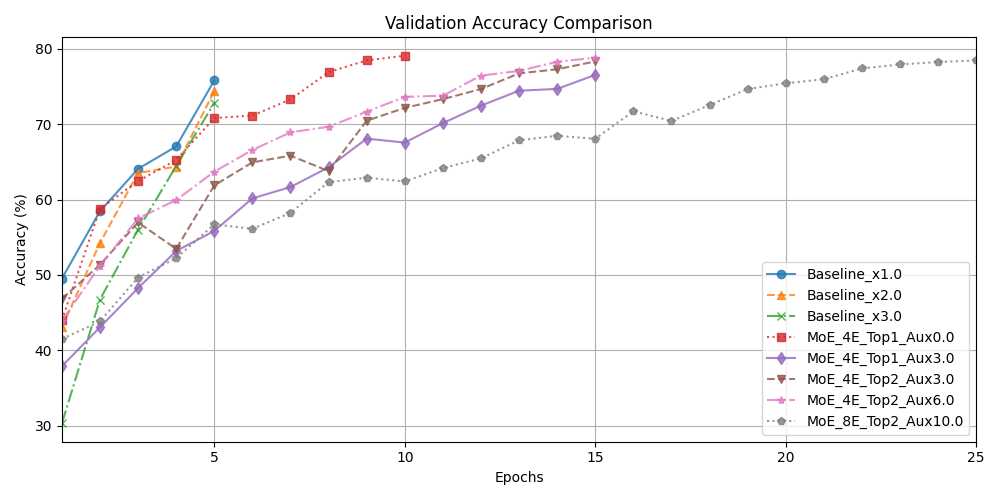

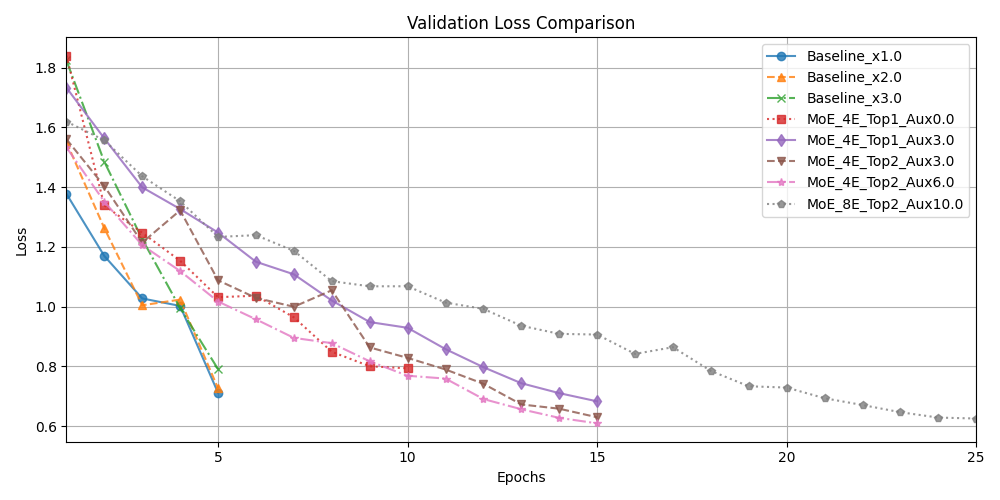

In [4]:
# Combine all histories for plotting
all_histories = {**baseline_histories, **moe_histories}

# Plot multimodel comparison
plot_multimodel_learning_curves(all_histories, SAVE_DIR)

# Display plots inline
from IPython.display import Image, display
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_accuracy.png')))
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_loss.png')))


## 2.2 Efficiency vs. Capacity
*   **Left:** Accuracy vs. Total Parameters (Storage Cost).
*   **Right:** Accuracy vs. Active Parameters (Inference Cost/Speed).

=== Accuracy vs Total Parameters (Storage) ===


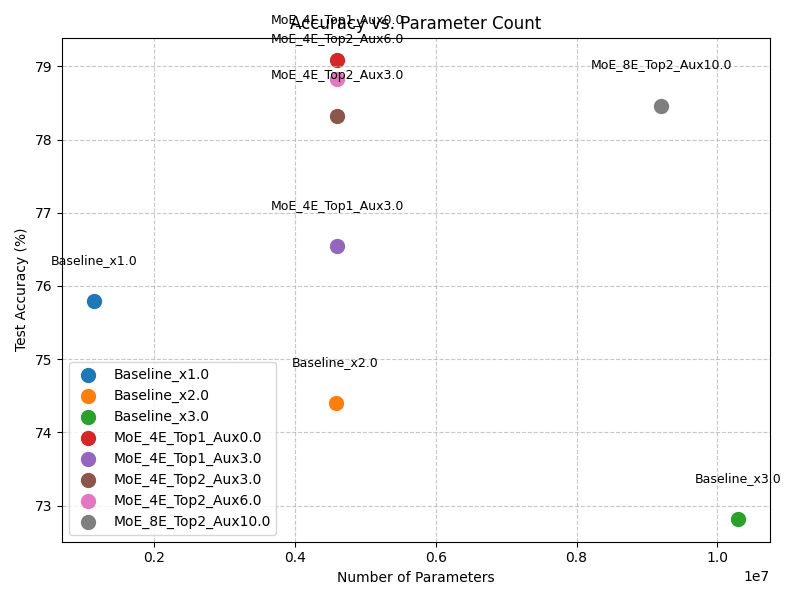


=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===


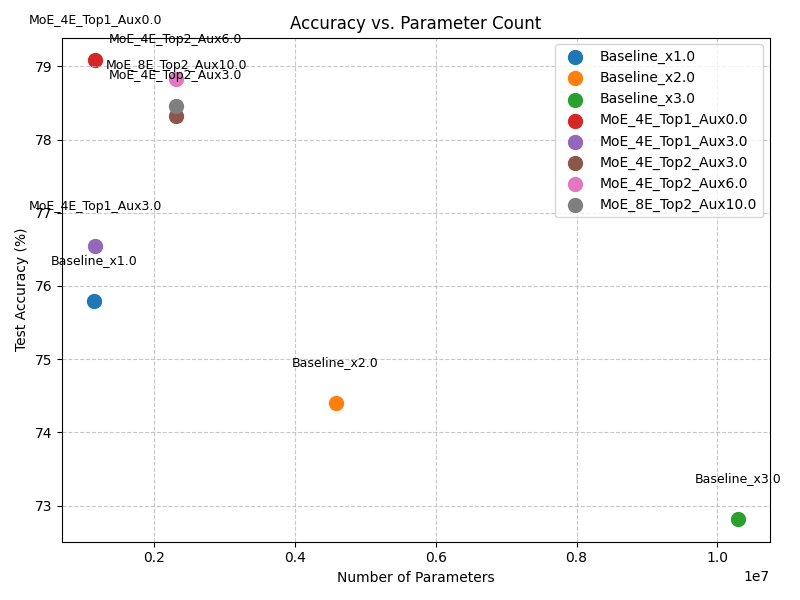

In [5]:
storage_data = [] # Accuracy vs Total Params
compute_data = [] # Accuracy vs Active Params

# Process Baselines
for name, model in baseline_models.items():
    acc = baseline_histories[name].history['val_acc'][-1]
    total_p = count_total_params(model)
    # For dense models, active = total
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': total_p, 'accuracy': acc})

# Process MoEs
for name, model in moe_models.items():
    acc = moe_histories[name].history['val_acc'][-1]
    
    total_p = count_total_params(model)
    active_p = count_active_params_moe(model)
    
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': active_p, 'accuracy': acc})

# Plot 1: Storage
print("=== Accuracy vs Total Parameters (Storage) ===")
compare_params_vs_performance(storage_data, os.path.join(SAVE_DIR, 'acc_vs_storage.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_storage.png')))

# Plot 2: Compute
print("\n=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===")
compare_params_vs_performance(compute_data, os.path.join(SAVE_DIR, 'acc_vs_compute.png'))
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_compute.png')))


# 3. Gating & Expert Analysis

We analyze how experts are utilized and how they learn.
*   **Utilization Histogram:** Did the experts handle an equal share of data?
*   **Counts Evolution:** How many samples per expert over time?
*   **Loss Evolution:** Did experts learn at the same speed?


--- Analyzing MoE_4E_Top1_Aux0.0 ---


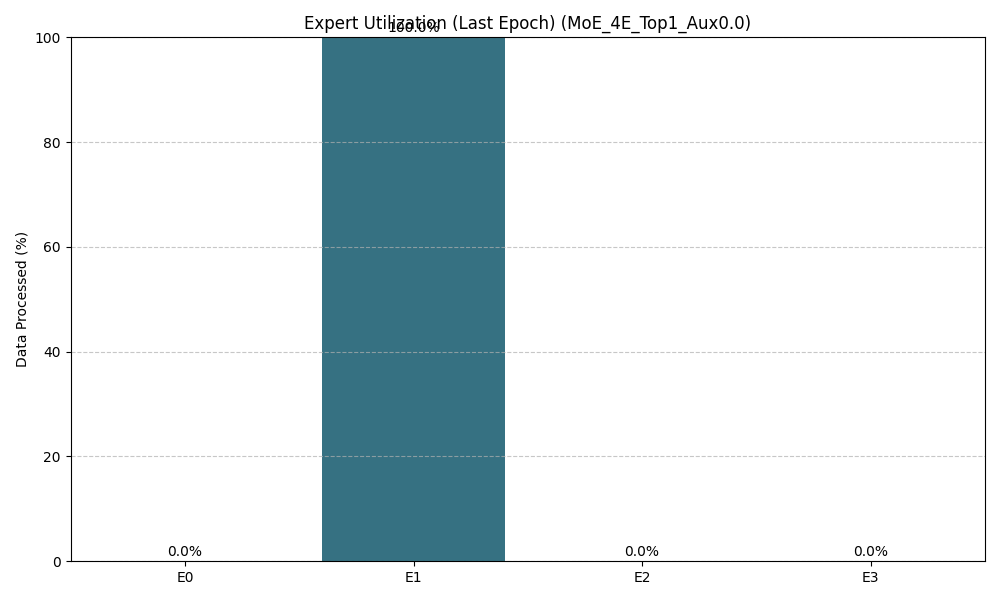

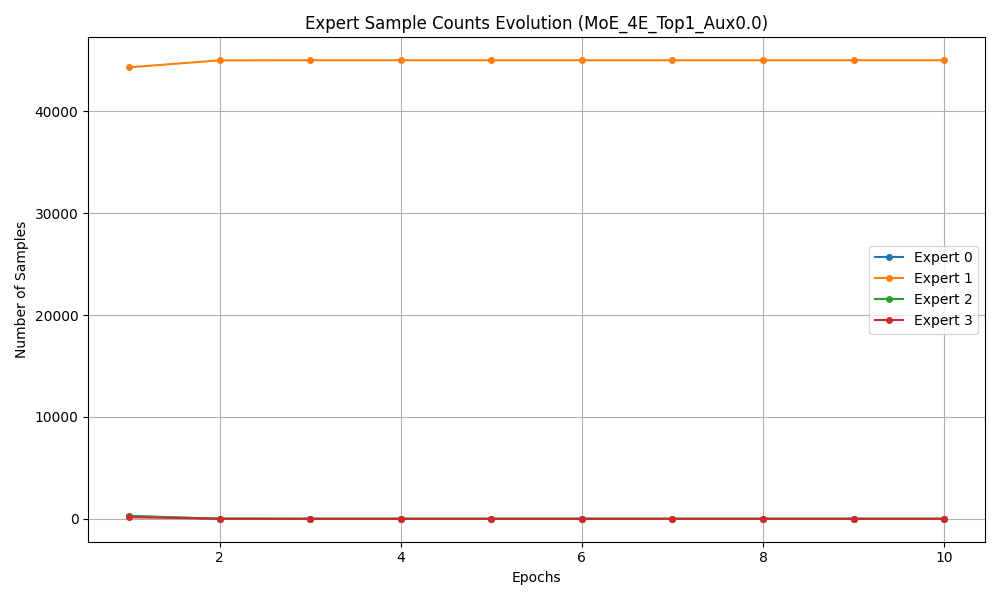

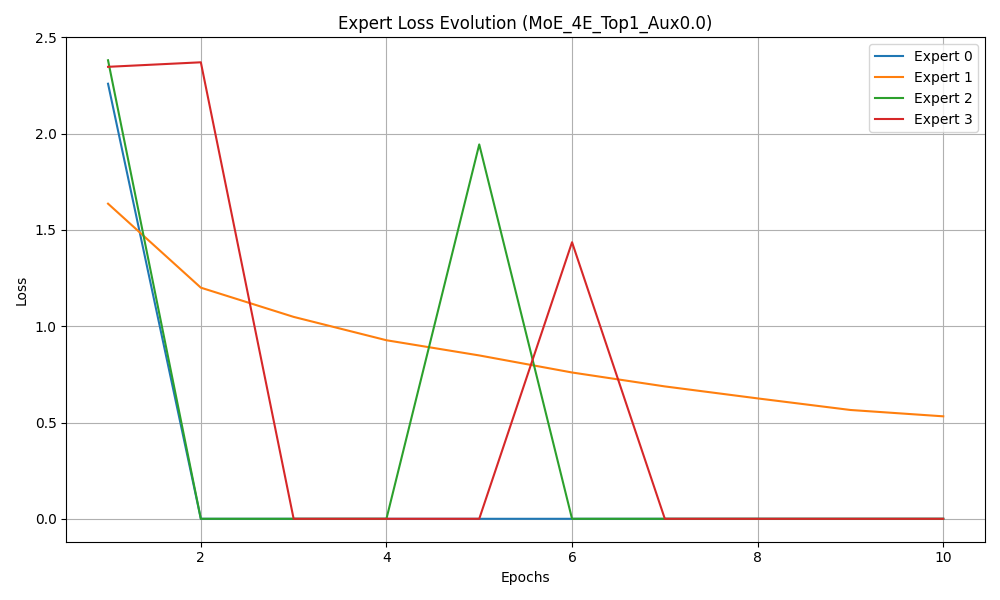


--- Analyzing MoE_4E_Top1_Aux3.0 ---


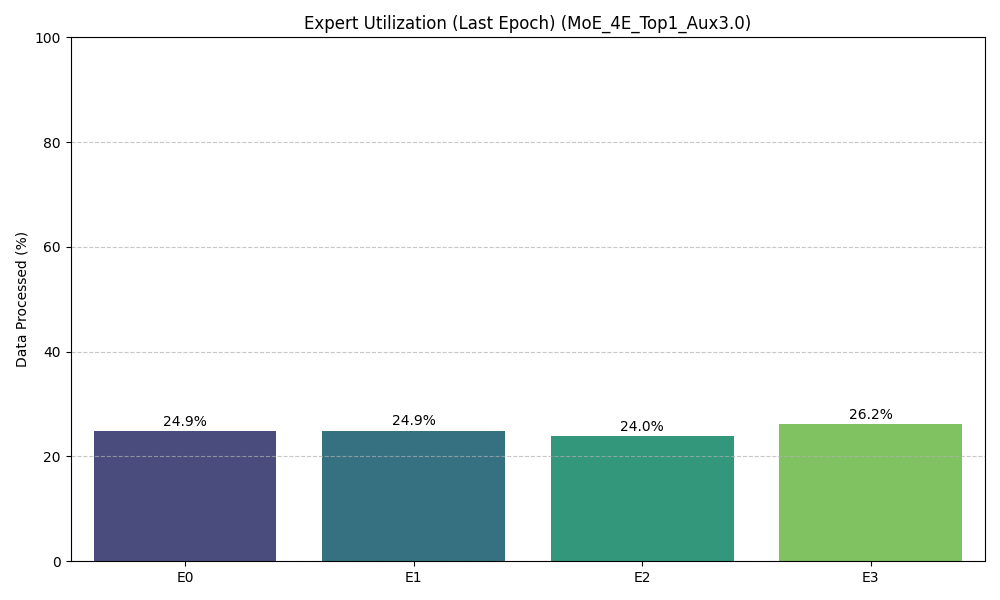

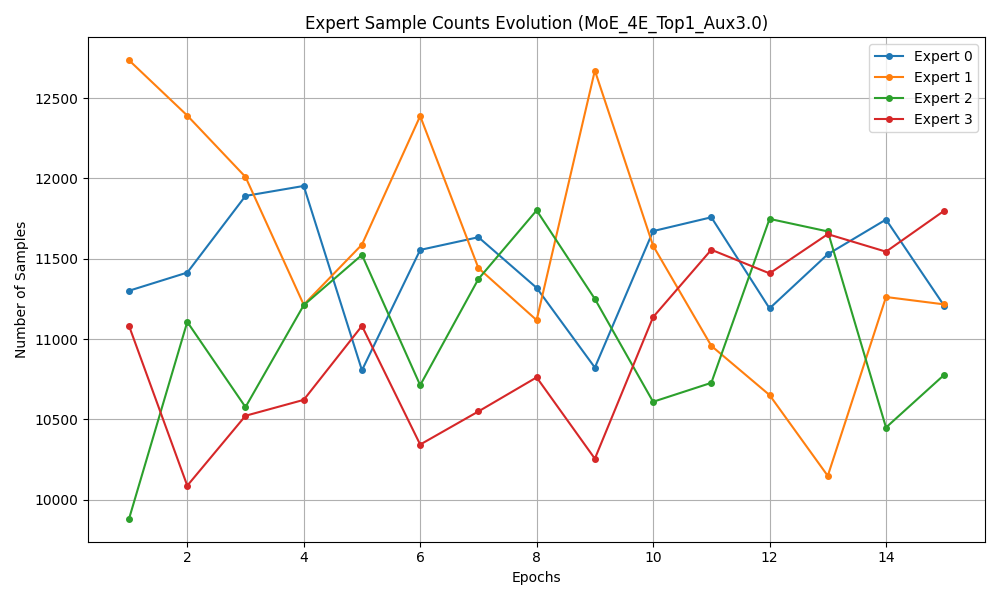

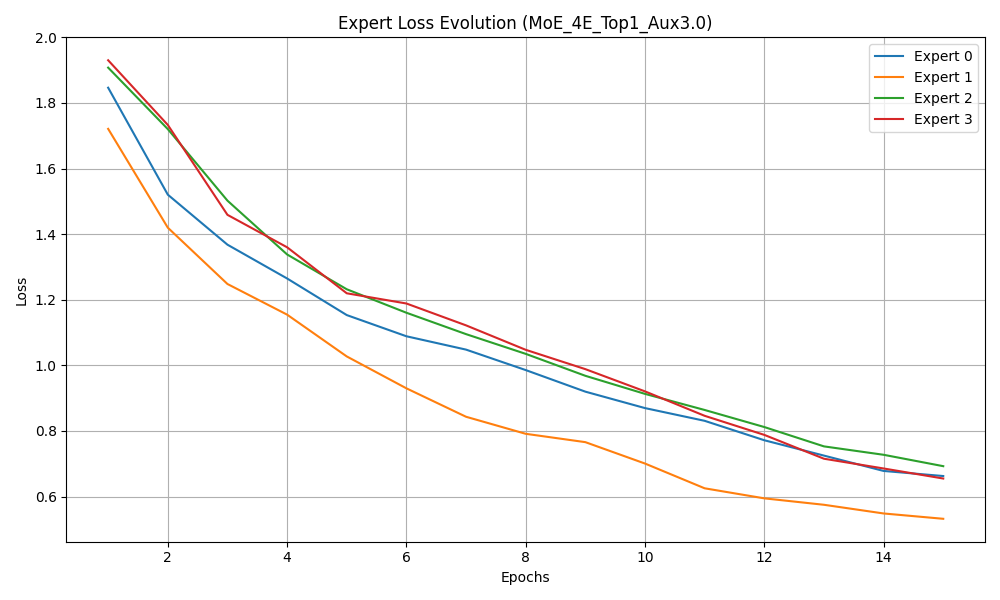


--- Analyzing MoE_4E_Top2_Aux3.0 ---


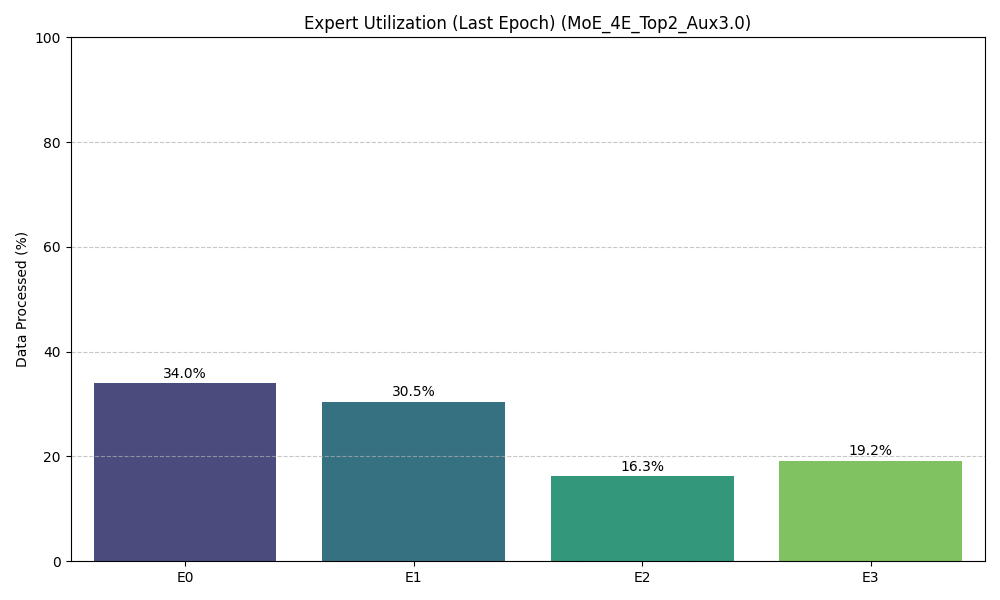

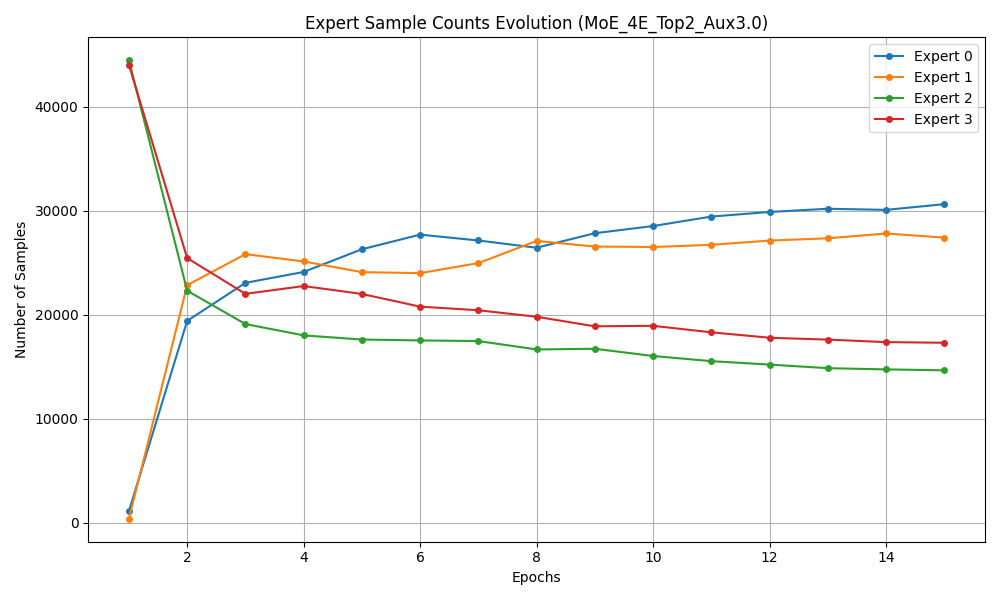

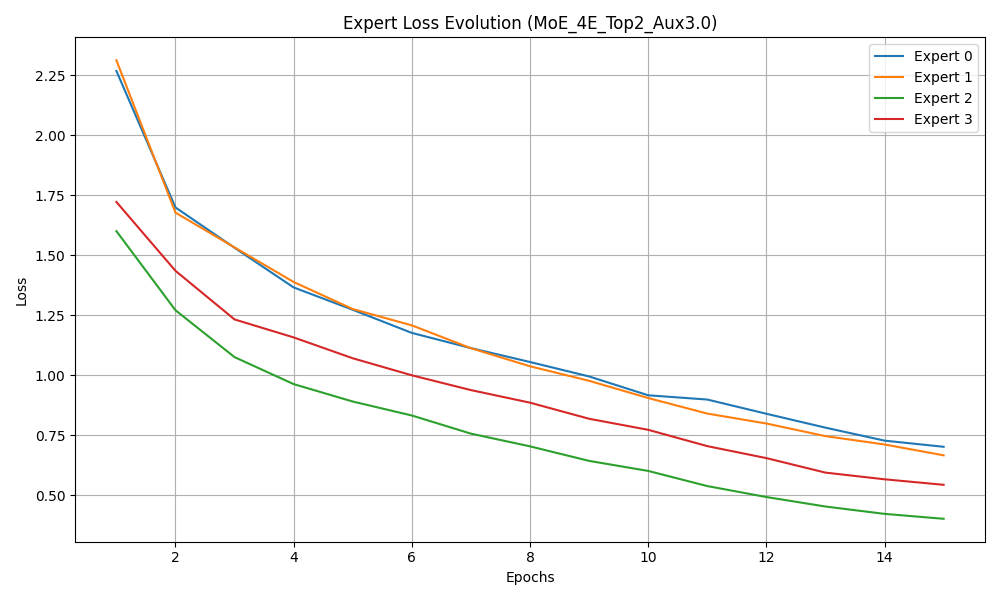


--- Analyzing MoE_4E_Top2_Aux6.0 ---


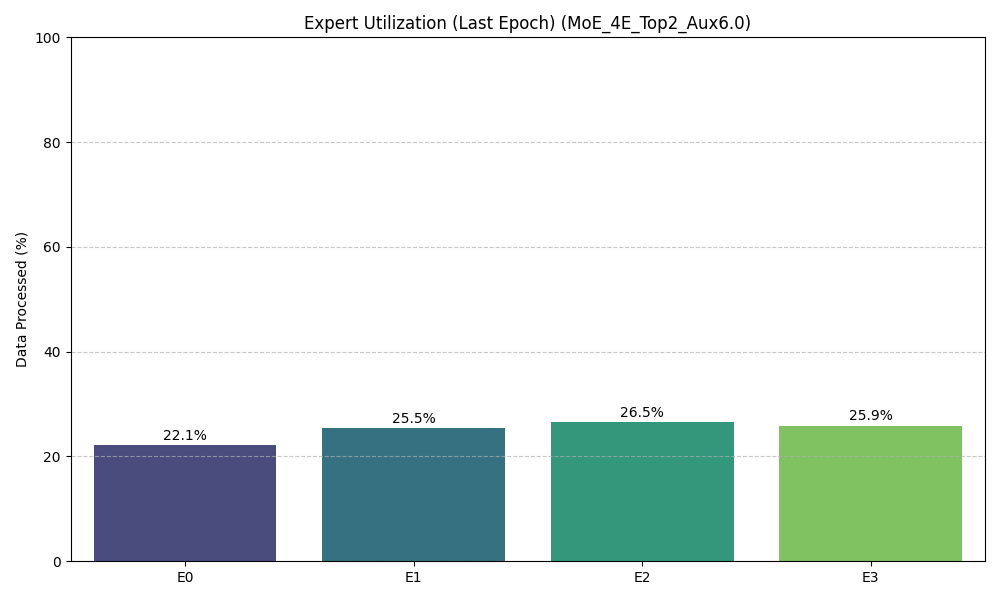

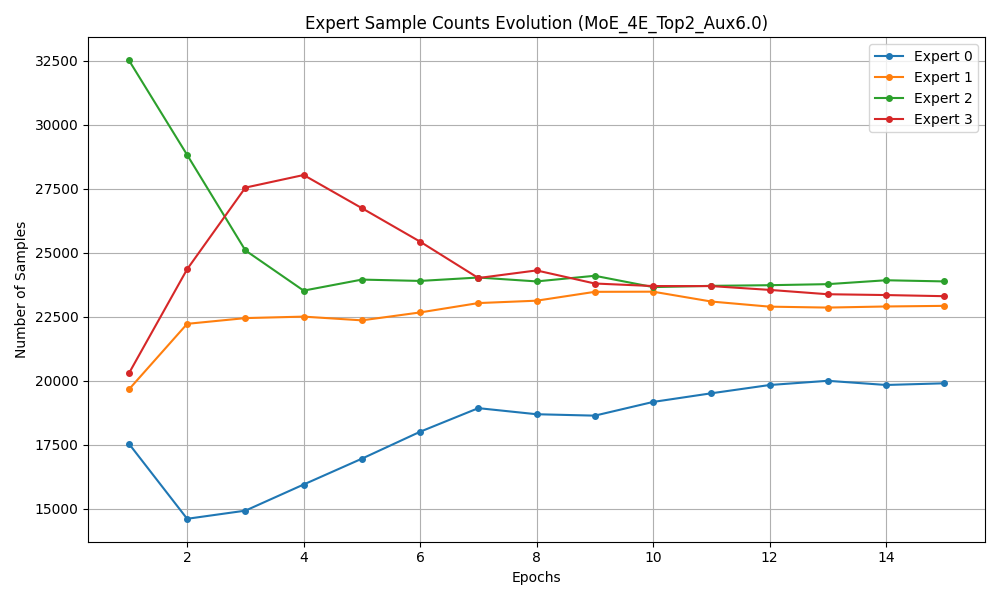

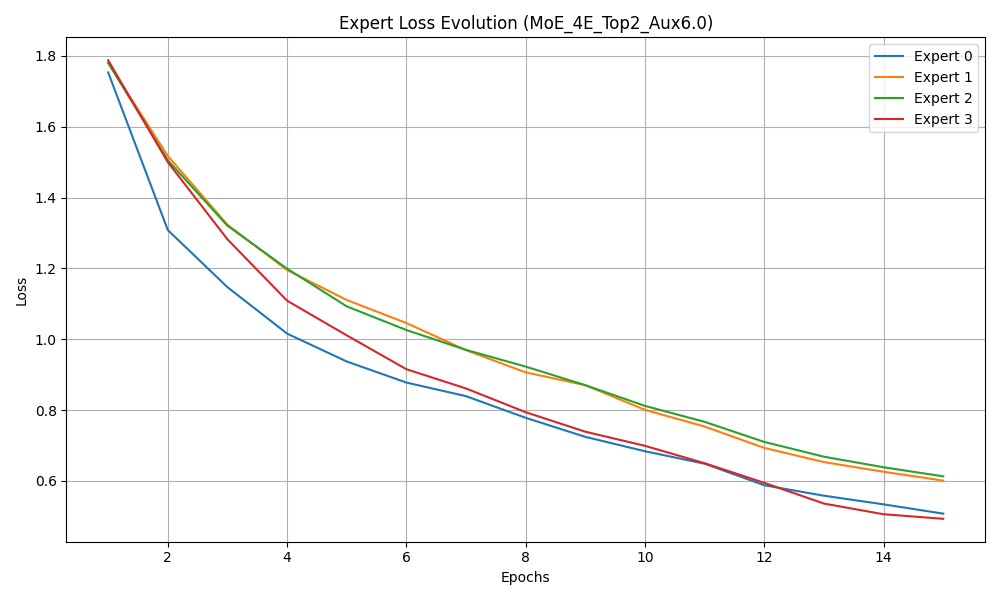


--- Analyzing MoE_8E_Top2_Aux10.0 ---


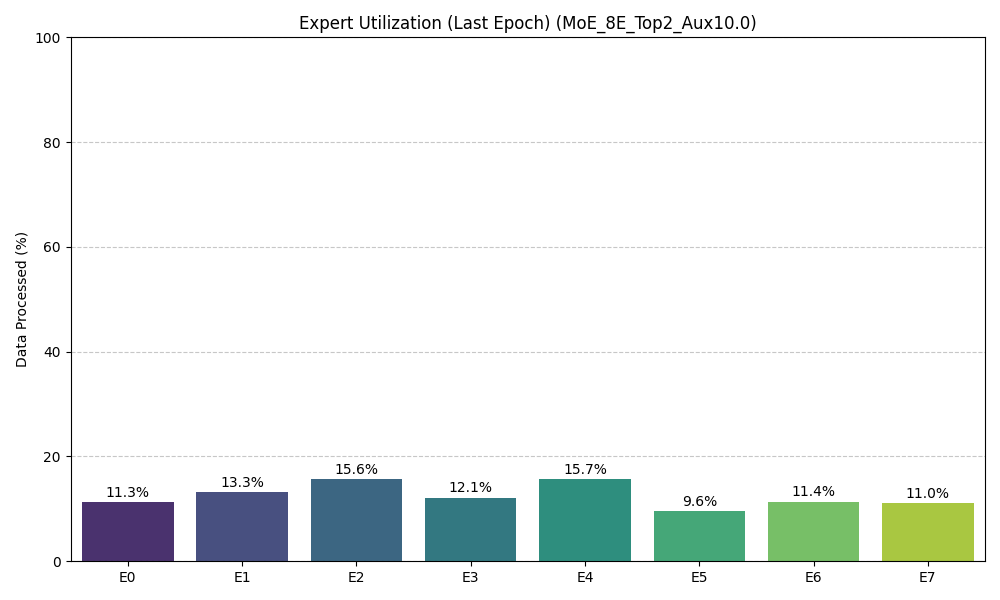

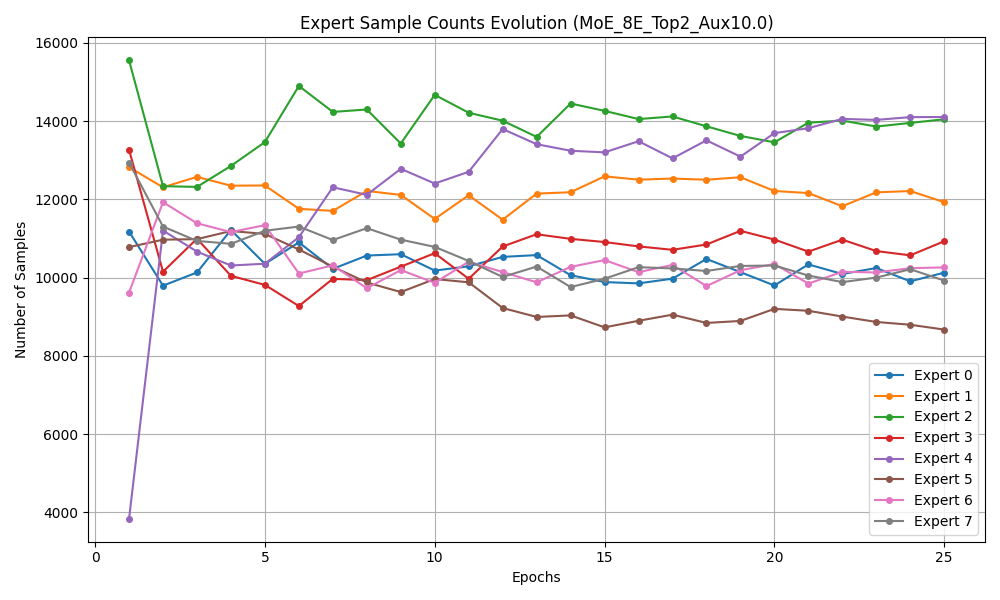

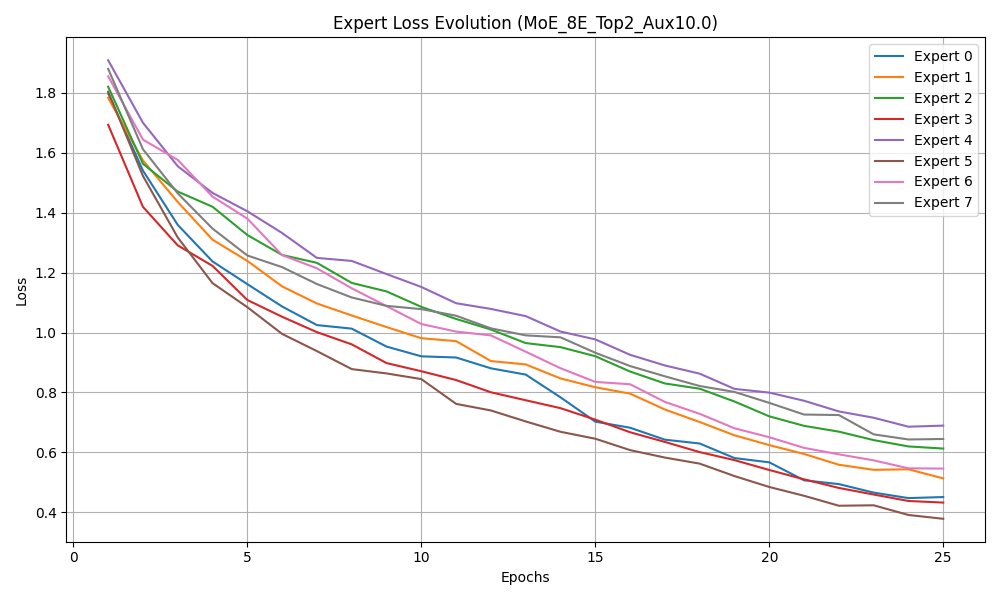

In [8]:
# Analyze each MoE configuration
for name in moe_histories.keys():
    print(f"\n--- Analyzing {name} ---")
    hist = moe_histories[name]
    
    # 1. Expert Usage Histogram (Last Epoch)
    plot_expert_utilization_histogram(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_utilization_histogram{f"({name})".replace(" ", "_").lower()}.png')))
    
    # 1b. Expert Usage Evolution (Stacked Area)
    # plot_expert_utilization(hist, SAVE_DIR) # Generates 'expert_utilization_evolution.png'
    # Rename it to keep unique
    # os.rename(os.path.join(SAVE_DIR, 'expert_utilization_evolution.png'), 
    #           os.path.join(SAVE_DIR, f'expert_utilization_evolution_{name}.png'))
    
    # 2. Expert Counts Evolution (Line Plot)
    plot_expert_counts_evolution(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_counts_evolution{f"({name})".replace(" ", "_").lower()}.png')))

    # 3. Expert Loss Evolution
    plot_expert_loss_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_loss_evolution{f"({name})".replace(" ", "_").lower()}.png')))


# 4. Specialization
Do experts specialize in specific classes (e.g., Expert 0 -> Animals, Expert 1 -> Vehicles)?


--- Specialization: MoE_4E_Top1_Aux0.0 ---


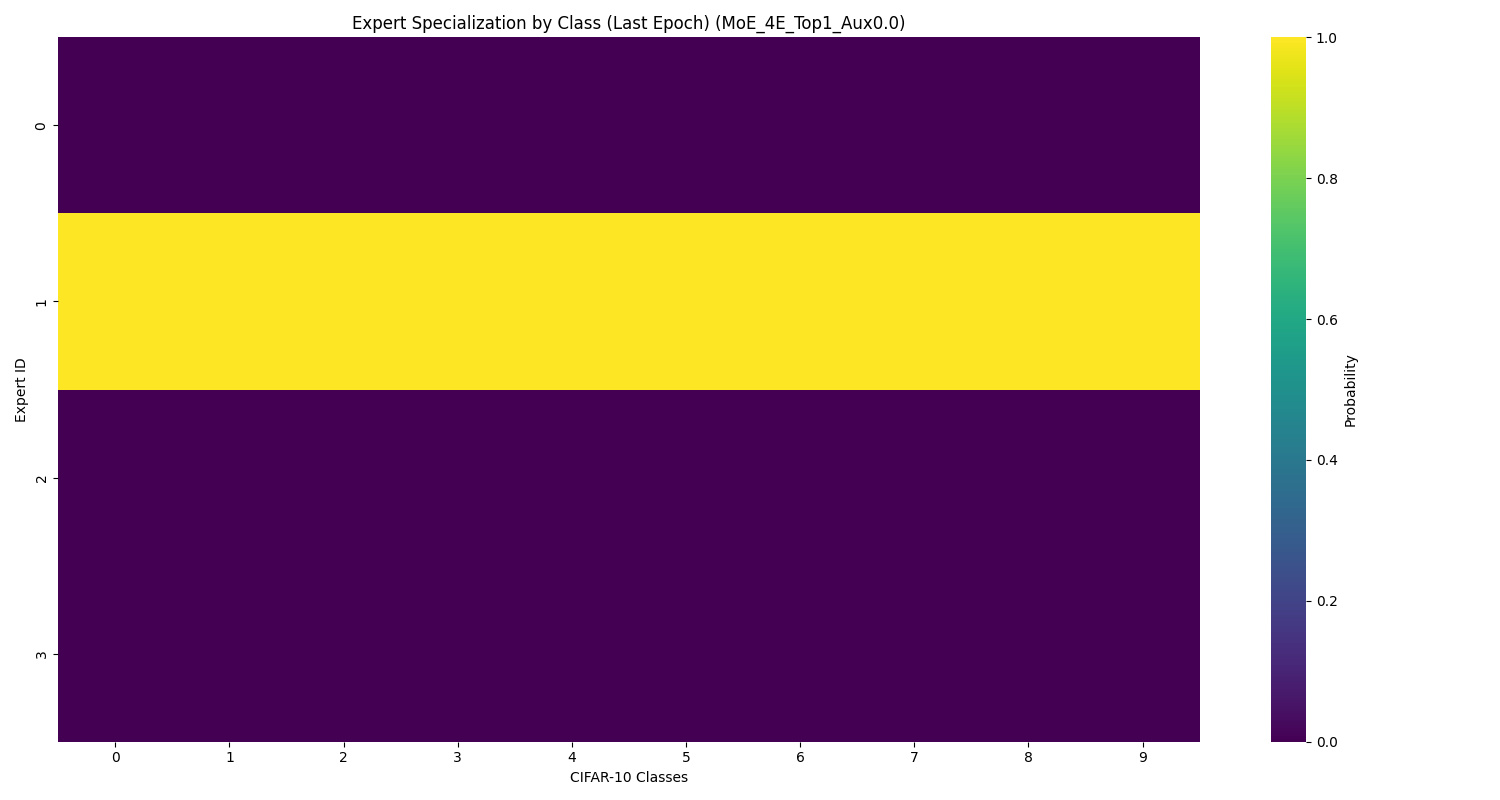


--- Specialization: MoE_4E_Top1_Aux3.0 ---


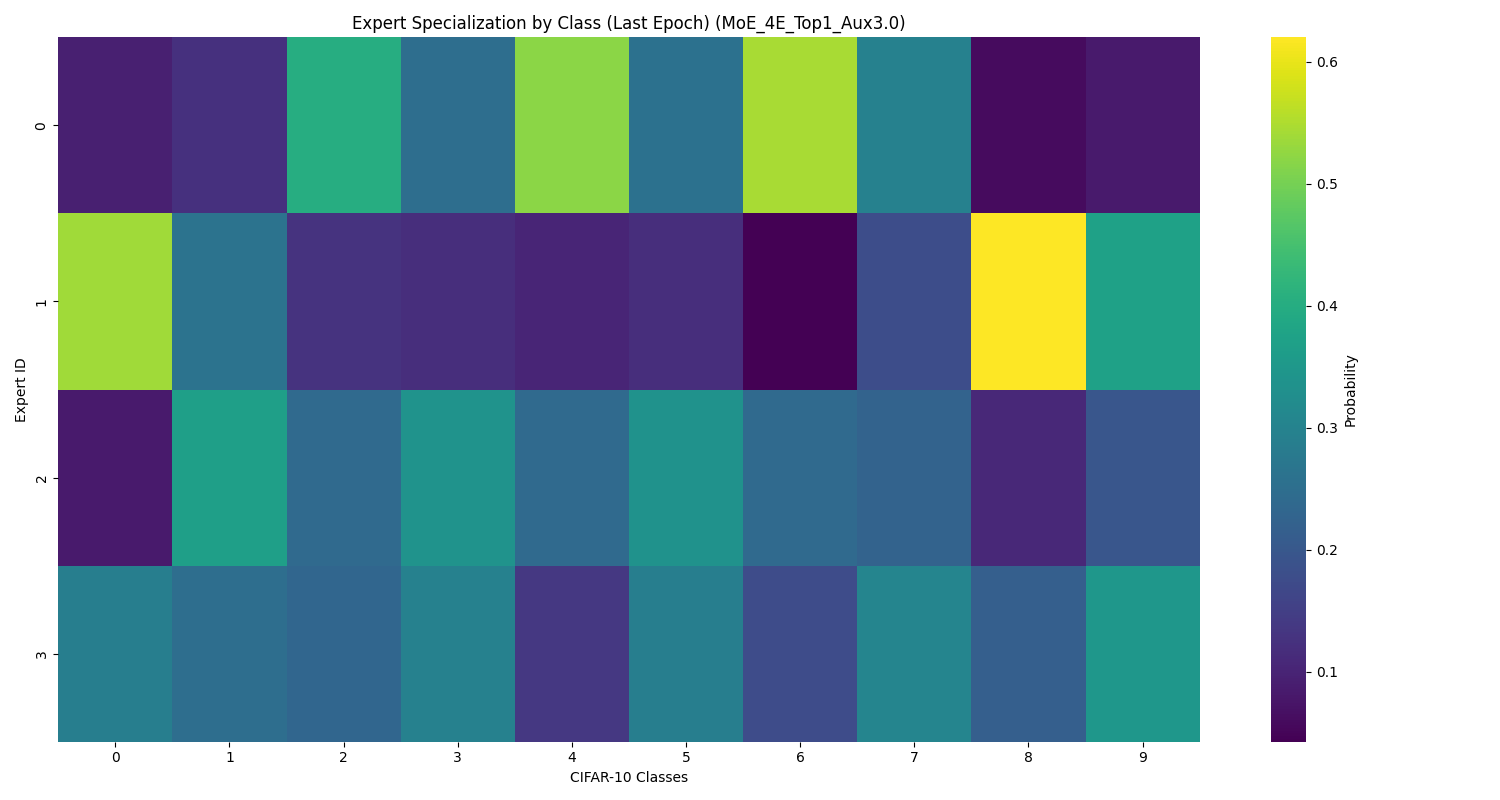


--- Specialization: MoE_4E_Top2_Aux3.0 ---


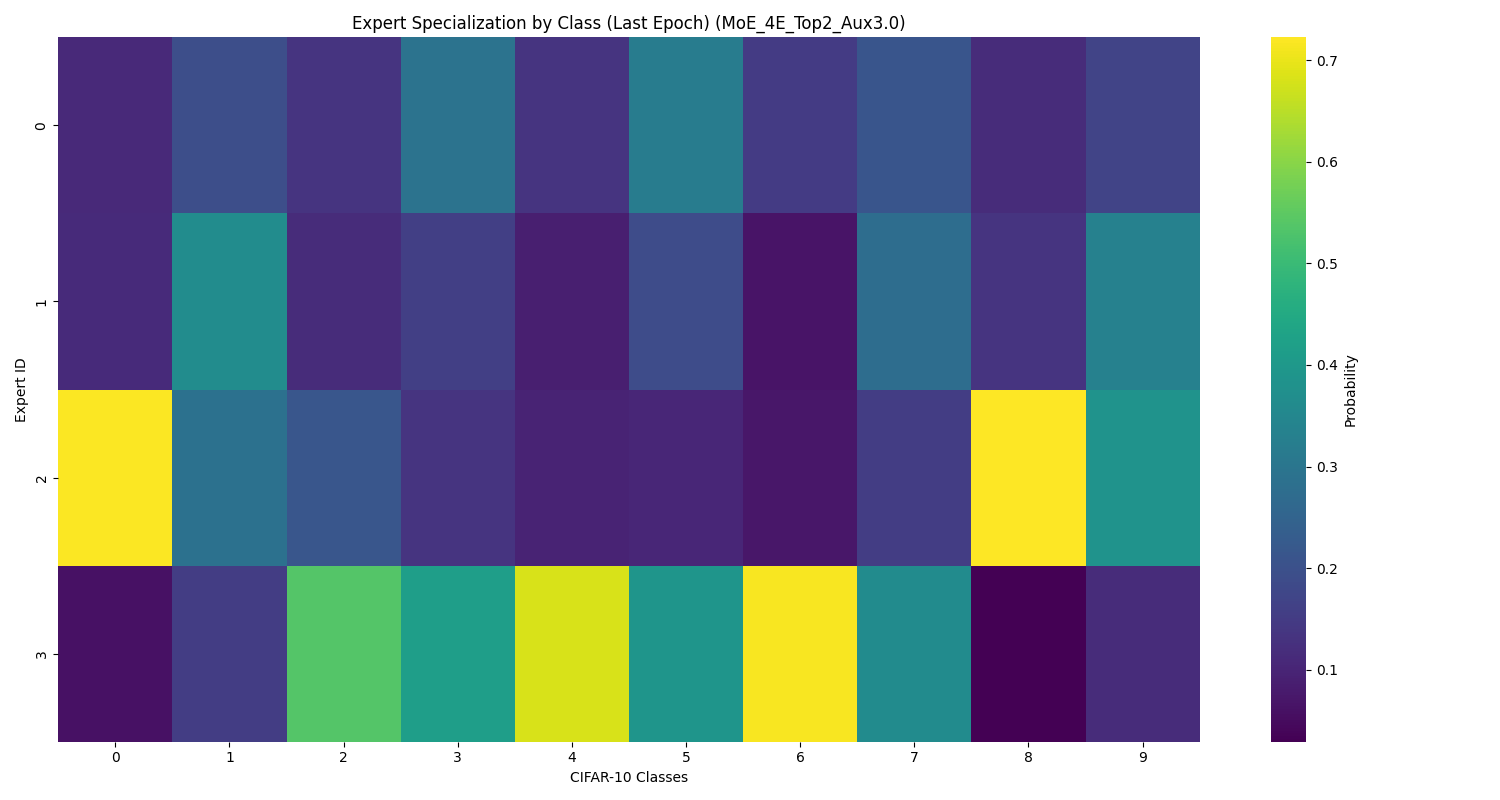


--- Specialization: MoE_4E_Top2_Aux6.0 ---


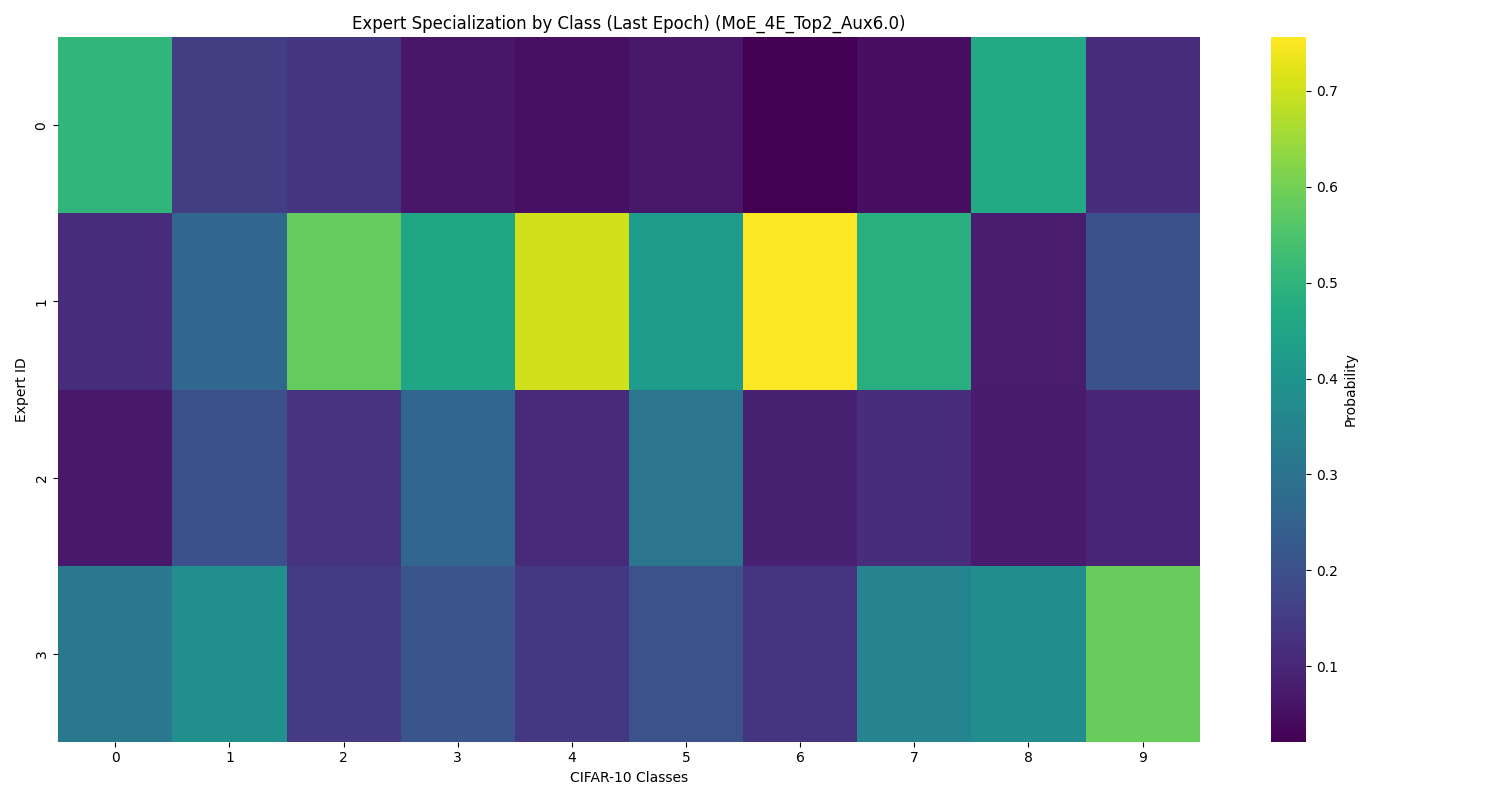


--- Specialization: MoE_8E_Top2_Aux10.0 ---


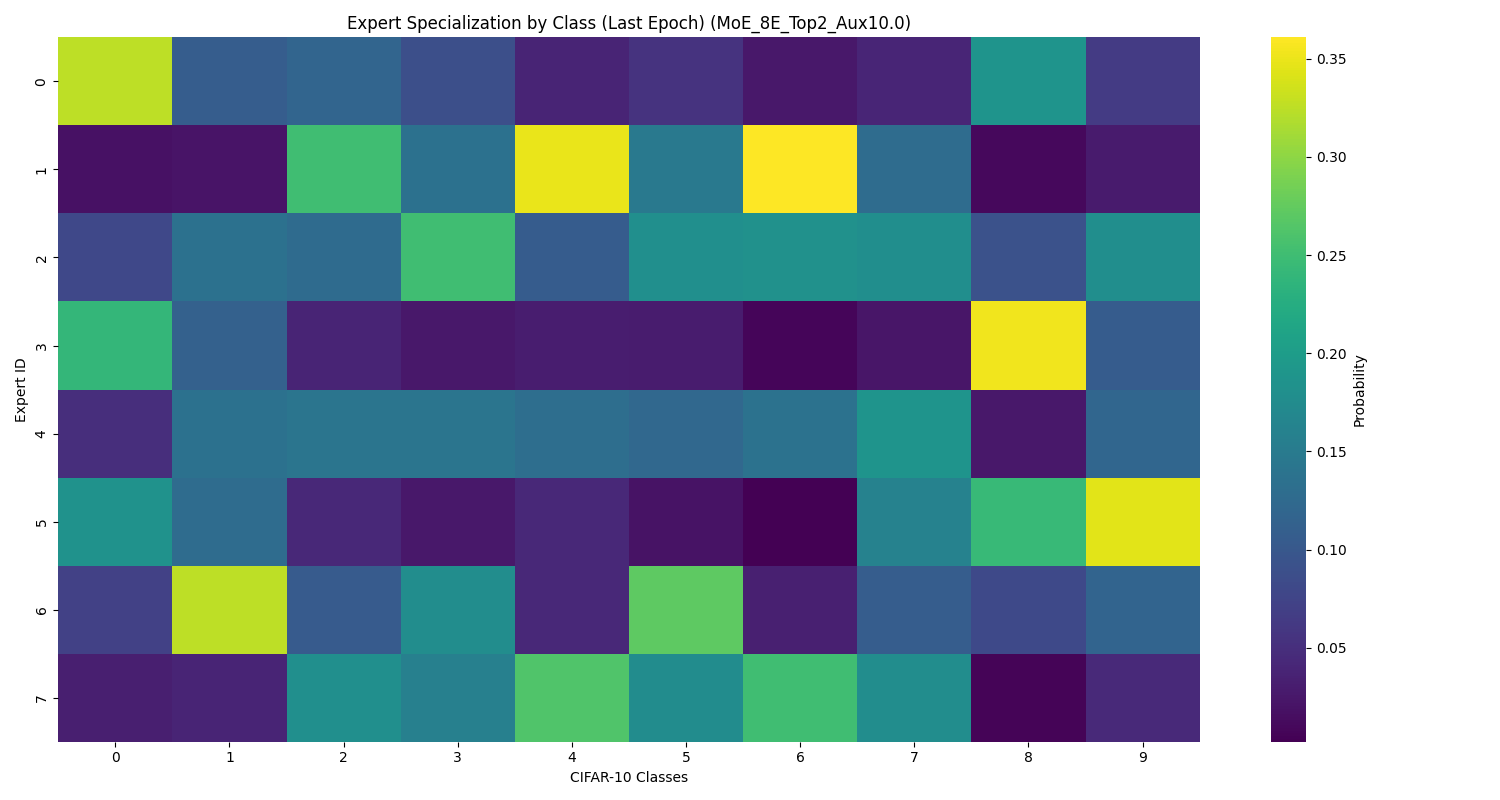

In [7]:
for name in moe_histories.keys():
    print(f"\n--- Specialization: {name} ---")
    hist = moe_histories[name]
    
    plot_expert_heatmap_from_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_specialization_heatmap{f"({name})".replace(" ", "_").lower()}.png')))
